# Plots for the 2MDM analysis

In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import pandas as pd
import glob,imp,os,shutil
from pandas import json_normalize

import pyslha
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.patches as mpatches
from collections import OrderedDict
import seaborn as sns
from scipy.interpolate import LinearNDInterpolator,interp2d, griddata
from itertools import product
from IPython.display import display, Markdown

pd.option_context('display.max_columns', -1)

pd.options.mode.chained_assignment = None #Disable copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')

/tmp/ipykernel_2328160/1200496628.py:5: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import glob,imp,os,shutil


#### Create txname/process translator

In [2]:
processDict = {'TRV1tt' : r'$p p \to Z^{\prime} \to \bar{t} t$',
               'TRV1jj' : r'$p p \to Z^{\prime} \to j j$',
               'TRV1bb' : r'$p p \to Z^{\prime} \to \bar{b} b$',
               'TRV1' : r'$p p \to Z^{\prime} \to \chi \chi$',
               'TRS1' : r'$p p \to S \to \chi \chi$'}
def convertLabel(label):
    newlabel = label[:]
    #Replace txnames by process
    for txlabel,proc in processDict.items():
        newlabel = newlabel.replace(txlabel,proc) 
    return newlabel

#### Get data in pcl format

In [3]:
#Merge with SModelS DataFrame
pclFiles = ['../../data/smodels_results/2mdm_results.pcl', '../../data/smodels_results/2mdm_results_gqv_025.pcl']
dfs = [pd.read_pickle(i) for i in pclFiles]
dataDF = pd.concat(dfs, ignore_index=True)
print(dataDF.columns.values.tolist()) #Print all columns names

['filename', 'mass.9000006', 'mass.9900032', 'mass.9900026', 'width.9000006', 'width.9900026', 'width.9900032', 'extpar.1', 'extpar.2', 'extpar.3', 'extpar.4', 'extpar.5', 'extpar.6', 'extpar.7', 'xsec13TeV(fb).9900032', 'xsec13TeV(fb).9900026', 'BRs.sd.W-,W+', 'BRs.sd.higgs,higgs', 'BRs.sd.Z,Z', 'BRs.sd.t-,t+', 'BRs.zp.b,b', 'BRs.zp.c,c', 'BRs.zp.q,q', 'BRs.zp.t-,t+', 'BRs.sd.chi,chi', 'BRs.zp.chi,chi', 'totalxsec13TeV(fb)', 'totalxsec8TeV(fb)', 'Total xsec for missing topologies (fb)', 'Total xsec for missing topologies with displaced decays (fb)', 'Total xsec for missing topologies with prompt decays (fb)', 'Total xsec for topologies outside the grid (fb)', 'OutputStatus.sigmacut', 'OutputStatus.minmassgap', 'OutputStatus.maxcond', 'OutputStatus.ncpus', 'OutputStatus.model', 'OutputStatus.promptwidth', 'OutputStatus.stablewidth', 'OutputStatus.eraseprompt', 'OutputStatus.checkinput', 'OutputStatus.doinvisible', 'OutputStatus.docompress', 'OutputStatus.computestatistics', 'OutputStat

#### Set r = 0 for points with no results 

In [4]:
#Set points without results with r == 0
dataDF.fillna(value={c : 0 for c in dataDF.columns if c.endswith('.r')}, inplace=True)
#Sort points according to r value:
dataDF = dataDF.sort_values(by=['ExptRes.result0.r'],ascending=False)

#### Define exclusions

In [5]:
#Add simple flag for excluded points:
dataDF['excludedLHC'] = dataDF['ExptRes.result0.r'] > 1.0

### Get points excluded:

In [6]:
excluded = dataDF[dataDF['excludedLHC'] == True]

allowed = dataDF[(dataDF['excludedLHC'] == False)]


print('Total number of points = %i' %len(dataDF))
print('Total excluded (LHC) = %i'%(len(excluded)))
print('Total allowed = %i\n'%(len(allowed)))

# print('Total excluded (r > %1.2f) = %i'%(rscale,len(excludedSC)))
# print('Total allowed (r > %1.2f) = %i'%(rscale,len(allowedSC)))


Total number of points = 1044
Total excluded (LHC) = 848
Total allowed = 196



## Get all exclusion curves

#### Get TxNames and analysis IDs

In [7]:
idCols = [c for c in dataDF.columns if 'AnalysisID' in c]
txCols = [c for c in dataDF.columns if 'TxNames' in c]
print(idCols)

['ExptRes.result0.AnalysisID', 'ExptRes.result1.AnalysisID', 'ExptRes.result2.AnalysisID', 'ExptRes.result3.AnalysisID', 'ExptRes.result4.AnalysisID', 'ExptRes.result5.AnalysisID']


In [8]:
ana, tx = [], []
for c in idCols:
    for i in dataDF[c].dropna().unique():
        ana.append(i)
        
for c in txCols:
    for txlist in dataDF[c].dropna():
        for i in txlist:
            tx.append(i)

In [9]:
txnames = pd.Series(tx).drop_duplicates().tolist()
analysis = pd.Series(ana).drop_duplicates().tolist()

#### Filter initial dataframe to include all results in just one column

In [10]:
filteredDF = []
# anaID = analysis
# txID = txnames
for irow,row in dataDF.iterrows():
    for anaID in analysis:
        for txID in txnames:
            resCols = [idc for idc in idCols if (row[idc] == anaID and (row[idc.replace('AnalysisID','TxNames')] == [txID]
                                                                       or row[idc.replace('AnalysisID','TxNames')] == ['TRS1', 'TRV1']))]
            if not resCols:
                continue
            resCol = resCols[0].rsplit('.',1)[0]
            newrow = {c.replace(resCol,'ExptRes.result') : row[c] for c in dataDF.columns if (('ExptRes' not in c) or (resCol in c))}
            filteredDF.append(newrow)  

In [11]:
newDF = pd.DataFrame.from_dict(filteredDF)

In [12]:
newDF[['ExptRes.result.AnalysisID','ExptRes.result.TxNames','ExptRes.result.r']]

,ExptRes.result.AnalysisID,ExptRes.result.TxNames,ExptRes.result.r
0,ATLAS-EXOT-2019-03,[TRV1jj],379.325900
1,ATLAS-EXOT-2019-03,[TRV1jj],376.395700
2,CMS-EXO-20-004,[TRV1],0.866492
3,ATLAS-EXOT-2019-03,[TRV1jj],372.595900
4,CMS-EXO-20-004,"[TRS1, TRV1]",1.975245
...,...,...,...
6242,CMS-EXO-19-012,[TRV1jj],0.006408
6243,CMS-EXO-20-004,[TRS1],0.000004
6244,ATLAS-EXOT-2018-48,[TRV1tt],0.011834
6245,CMS-EXO-20-008,[TRV1bb],0.004429


#### Get analysis IDs that excludes points

In [13]:
newDF['excluded'] = newDF['ExptRes.result.r'] > 1.0
excluded = newDF[newDF['excluded'] == True]
anas = excluded['ExptRes.result.AnalysisID'].value_counts()
anas.sort_values(inplace=True,ascending=False)

    
labels = []
for index, row in excluded.iterrows():
    ana = row['ExptRes.result.AnalysisID']
    txList = sorted(row['ExptRes.result.TxNames'])
    label = ana + ' (' + ','.join(txList) + ')'
    labels.append(label)
excluded['label'] = labels

labels = []
for index, row in newDF.iterrows():
    ana = row['ExptRes.result.AnalysisID']
    txList = sorted(row['ExptRes.result.TxNames'])
    label = ana + ' (' + ','.join(txList) + ')'
    labels.append(label)
newDF['label'] = labels

In [14]:
newDF = newDF.replace(to_replace='CMS-EXO-20-004 (TRS1,TRV1)', value='CMS-EXO-20-004 (TRV1)')
excluded = excluded.replace(to_replace='CMS-EXO-20-004 (TRS1,TRV1)', value='CMS-EXO-20-004 (TRV1)')

#### Aux variables for plotting

In [15]:
# plotting aux

colors = sns.color_palette("colorblind",len(excluded['label'].unique()))

colorDict = {}

for i, l in enumerate(excluded['label'].unique()):
    colorDict[l] = np.array(colors[i]).reshape(-1,3)
    
legend = []
for ana, color in colorDict.items():
    l = mpatches.Patch(color=color, label=convertLabel(ana))
    legend.append(l)

#### Plot $m_{Z^{\prime}}$ vs $m_{\chi}$

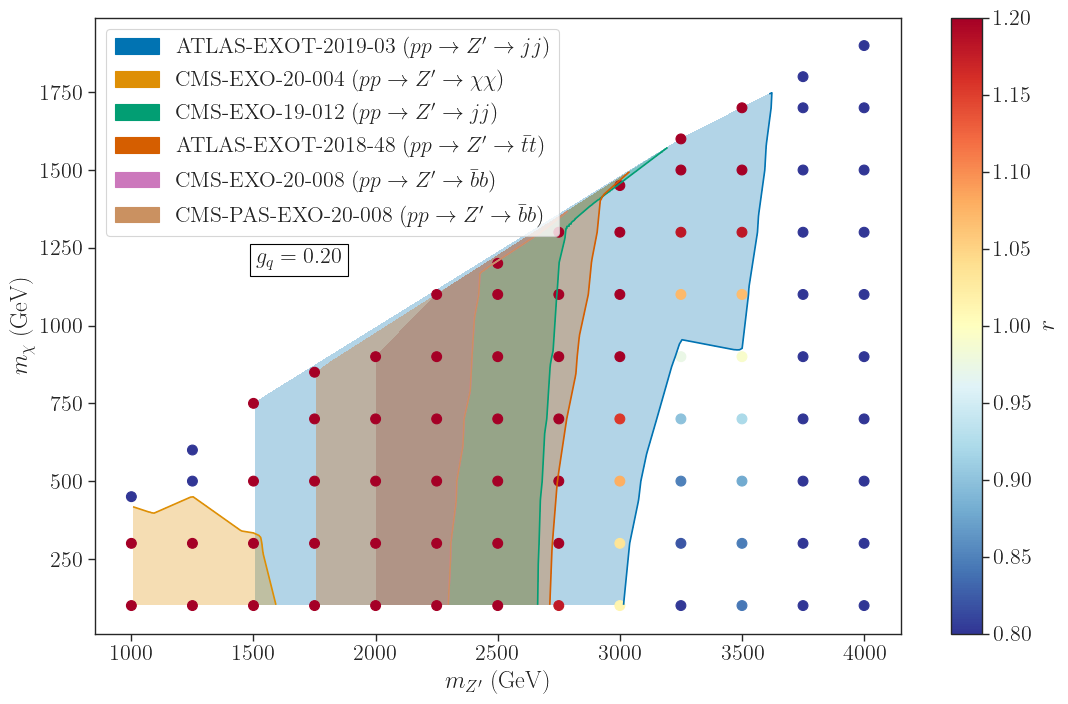

In [16]:
cm = plt.cm.get_cmap('RdYlBu_r')
plt.figure(figsize=(13,8))

gqv = 0.2

x = dataDF['mass.9900032'][dataDF['extpar.2']==gqv]
y = dataDF['mass.9000006'][dataDF['extpar.2']==gqv]
c = dataDF['ExptRes.result0.r'][dataDF['extpar.2']==gqv]

for label in excluded['label'].unique():
#     if label == 'CMS-PAS-EXO-20-008 (TRV1bb)': continue
    data = newDF[(newDF['extpar.2']==gqv) & (newDF['label']==label)]
    rData = data['ExptRes.result.r']
    if len(data[data['label'] == label]) < 7: continue
    pts = np.array([y for y in product(np.linspace(900.,4100.,300),np.linspace(0.,1800.,300))])
    rPts = griddata(list(zip(data['mass.9900032'],data['mass.9000006'])),rData,pts)
    pts = pts[~np.isnan(rPts)]
    rPts = rPts[~np.isnan(rPts)]
    cs = plt.tricontour(pts[:,0],pts[:,1],rPts,levels=[1.0], colors=colorDict[label])
    plt.tricontourf(pts[:,0],pts[:,1], rPts, levels=[1.0, max(rPts)], alpha=0.3, colors=colorDict[label])
    
    
plt.legend(handles=[legend[0], legend[1], legend[2], legend[3], legend[4], legend[5]])

plt.scatter(x,y,c=c,s=50,cmap=cm, vmin=0.8,vmax=1.2)
plt.colorbar(label=r'$r$')
plt.xlabel(r'$m_{Z^{\prime}}$ (GeV)')
plt.ylabel(r'$m_{\chi}$ (GeV)')
plt.text(0.2,0.6,r"$g_{q} = %1.2f$" %gqv,fontsize=16,bbox=dict(facecolor='white', edgecolor='black'),
         transform = plt.gca().transAxes)

plt.show()

#### Plot $m_{Z^{\prime}}$ vs $g_{q}$

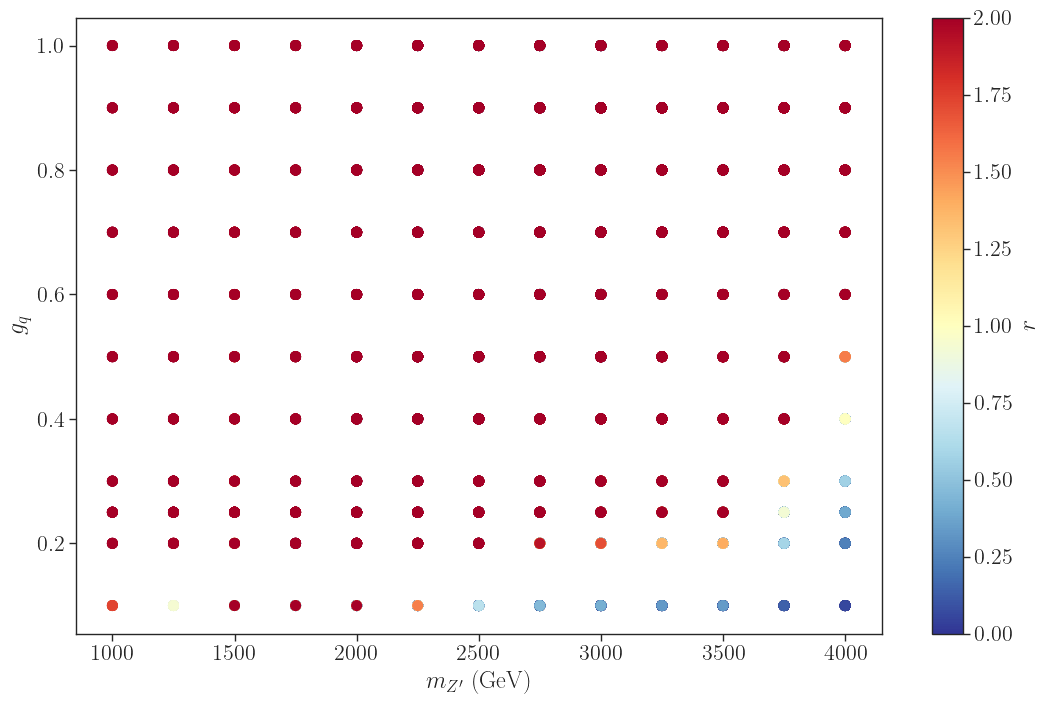

In [28]:
cm = plt.cm.get_cmap('RdYlBu_r')
plt.figure(figsize=(13,8))


x = newDF['mass.9900032']
y = newDF['extpar.2']
c = newDF['ExptRes.result.r']
x = x[c.argsort()]
y = y[c.argsort()]
c = c[c.argsort()]

# for label in excluded['label'].unique():
#     if label == 'CMS-PAS-EXO-20-008 (TRV1bb)': continue
#     data = newDF[(newDF['label']==label)]
#     rData = data['ExptRes.result.r']
#     if len(data[data['label'] == label]) < 7: continue
#     pts = np.array([y for y in product(np.linspace(900.,4100.,300),np.linspace(0.,1800.,300))])
#     rPts = griddata(list(zip(x,y)),rData,pts)
#     pts = pts[~np.isnan(rPts)]
#     rPts = rPts[~np.isnan(rPts)]
#     cs = plt.tricontour(pts[:,0],pts[:,1],rPts,levels=[1.0], colors=colorDict[label])
#     plt.tricontourf(pts[:,0],pts[:,1], rPts, levels=[1.0, max(rPts)], alpha=0.3, colors=colorDict[label])
    
    
# plt.legend(handles=[legend[0], legend[1], legend[2], legend[3], legend[4], legend[5]])

plt.scatter(x,y,c=c,s=50,cmap=cm, vmin=0.0,vmax=2.0)
plt.colorbar(label=r'$r$')
plt.xlabel(r'$m_{Z^{\prime}}$ (GeV)')
plt.ylabel(r'$g_{q}$')

plt.show()

### Compare with zp only results

In [64]:
#Merge with SModelS DataFrame
pclFiles_zp = ['../../data/2mdm_results/zp_only/results.pcl', '../../data/2mdm_results_gqv_025/zp_only/results.pcl']
dfs = [pd.read_pickle(i) for i in pclFiles_zp]
dataDF_zp = pd.concat(dfs, ignore_index=True)


In [65]:
#Set points without results with r == 0
dataDF_zp.fillna(value={c : 0 for c in dataDF_zp.columns if c.endswith('.r')}, inplace=True)
#Sort points according to r value:
dataDF_zp = dataDF_zp.sort_values(by=['ExptRes.result0.r'],ascending=False)

#### Get TxNames and analysis IDs

In [66]:
idCols = [c for c in dataDF_zp.columns if 'AnalysisID' in c]
txCols = [c for c in dataDF_zp.columns if 'TxNames' in c]
print(idCols)

['ExptRes.result0.AnalysisID', 'ExptRes.result1.AnalysisID', 'ExptRes.result2.AnalysisID', 'ExptRes.result3.AnalysisID', 'ExptRes.result4.AnalysisID', 'ExptRes.result5.AnalysisID']


In [67]:
ana, tx = [], []
for c in idCols:
    for i in dataDF_zp[c].dropna().unique():
        ana.append(i)
        
for c in txCols:
    for txlist in dataDF_zp[c].dropna():
        for i in txlist:
            tx.append(i)

In [68]:
txnames = pd.Series(tx).drop_duplicates().tolist()
analysis = pd.Series(ana).drop_duplicates().tolist()

#### Filter initial dataframe to include all results in just one column

In [69]:
filteredDF_zp = []
# anaID = analysis
# txID = txnames
for irow,row in dataDF_zp.iterrows():
    for anaID in analysis:
        for txID in txnames:
            resCols = [idc for idc in idCols if (row[idc] == anaID and (row[idc.replace('AnalysisID','TxNames')] == [txID]))]
            if not resCols:
                continue
            resCol = resCols[0].rsplit('.',1)[0]
            newrow = {c.replace(resCol,'ExptRes.result') : row[c] for c in dataDF_zp.columns if (('ExptRes' not in c) or (resCol in c))}
            filteredDF_zp.append(newrow)  

In [70]:
newDF_zp = pd.DataFrame.from_dict(filteredDF_zp)

In [71]:
newDF_zp['excluded'] = newDF_zp['ExptRes.result.r'] > 1.0
excluded = newDF_zp[newDF_zp['excluded'] == True]
anas = excluded['ExptRes.result.AnalysisID'].value_counts()
anas.sort_values(inplace=True,ascending=False)

    
labels = []
for index, row in excluded.iterrows():
    ana = row['ExptRes.result.AnalysisID']
    txList = sorted(row['ExptRes.result.TxNames'])
    label = ana + ' (' + ','.join(txList) + ')'
    labels.append(label)
excluded['label'] = labels

labels = []
for index, row in newDF_zp.iterrows():
    ana = row['ExptRes.result.AnalysisID']
    txList = sorted(row['ExptRes.result.TxNames'])
    label = ana + ' (' + ','.join(txList) + ')'
    labels.append(label)
newDF_zp['label'] = labels

In [72]:
newDF_zp = newDF_zp.replace(to_replace='CMS-EXO-20-004 (TRS1,TRV1)', value='CMS-EXO-20-004 (TRV1)')
excluded = excluded.replace(to_replace='CMS-EXO-20-004 (TRS1,TRV1)', value='CMS-EXO-20-004 (TRV1)')

In [75]:
len(newDF_zp['ExptRes.result.r'][(newDF_zp['ExptRes.result.AnalysisID'] == exp) & (newDF_zp['extpar.2'] == 0.2)])

47

In [76]:
newDF['ExptRes.result.r'][(newDF['label'] == 'CMS-EXO-20-004 (TRV1)') & (newDF['extpar.2'] == 0.2)]

2524    0.680517
2543    0.054930
2683    0.017295
2741    1.064227
2742    1.064227
          ...   
5251    0.028856
5252    0.028856
5461    0.741660
5549    0.550285
6140    0.092565
Name: ExptRes.result.r, Length: 135, dtype: float64

In [59]:
cm = plt.cm.get_cmap('RdYlBu_r')
plt.figure(figsize=(10,6))

# Select points 
gqv = 0.25
exp = 'CMS-EXO-20-004'
x = newDF_zp['mass.9900032'][(newDF_zp['ExptRes.result.AnalysisID'] == exp) & (newDF_zp['extpar.2'] == gqv)]
y = newDF_zp['mass.9000006'][(newDF_zp['ExptRes.result.AnalysisID'] == exp) & (newDF_zp['extpar.2'] == gqv)]
r_zp = np.array(newDF_zp['ExptRes.result.r'][(newDF_zp['ExptRes.result.AnalysisID'] == exp) & (newDF_zp['extpar.2'] == gqv)])
r_all = np.array(newDF['ExptRes.result.r'][(newDF['ExptRes.result.AnalysisID'] == exp) & (newDF['extpar.2'] == gqv)])
diff = np.abs(r_all - r_zp)/r_all
# selectCurve = ['CMS-EXO-20-004']
# # Contour plots
# for i, ana in enumerate(analysis):
#     if any(val not in ana for val in selectCurve): continue
#     rData = data_zp[ana]['r']
#     pts = np.array([y for y in product(np.linspace(800.,4100.,300),np.linspace(0.,1800.,300))])
#     rPts = griddata(list(zip(data_zp[ana]['mzp'],data_zp[ana]['mchi'])),rData,pts)
#     pts = pts[~np.isnan(rPts)]
#     rPts = rPts[~np.isnan(rPts)]
#     plt.tricontour(pts[:,0],pts[:,1],rPts,levels=[1.0], colors=colors[i])
#     plt.tricontourf(pts[:,0], pts[:,1], rPts, levels=[1.0, max(rPts)], colors=colors[i], alpha=0.5)
    
plt.scatter(x,y,c=c,s=50,cmap=cm, vmin=0.8,vmax=1.2)
# plt.plot(cmsCurve_axial['m_med_GeV'],cmsCurve_axial['m_chi_GeV'],label='CMS-EXO-20-004',linewidth=2,color='black')


plt.colorbar(label=r'$r$')
plt.xlabel(r'$m_{Z^{\prime}}$ (GeV)')
plt.ylabel(r'$m_{\chi}$ (GeV)')
plt.text(0.2,0.8,r"$g_{q} = %1.2f$" %gqv,fontsize=16,bbox=dict(facecolor='white', edgecolor='black'),
         transform = plt.gca().transAxes)


plt.ylim(50, 1400)
plt.xlim(900, 3100)
# plt.legend()
plt.show()

ValueError: operands could not be broadcast together with shapes (299,) (44,) 

<Figure size 1000x600 with 0 Axes>

In [58]:
diff

1302   NaN
1483   NaN
1510   NaN
1521   NaN
1619   NaN
        ..
5853   NaN
5881   NaN
5897   NaN
5903   NaN
5909   NaN
Name: ExptRes.result.r, Length: 340, dtype: float64

### Validate exclusion curve for CMS-EXO-20-004

In [53]:
cmsCurve = np.genfromtxt('2Dexclusioncontour,axial,Observed.csv', skip_header=12,names=True,delimiter=',')

In [54]:
## Get results with rescaled xsection that matches gchi = 1.0
pclFiles = ['../../data/smodels_results/2mdm_results_rescaled.pcl']
dfs = [pd.read_pickle(i) for i in pclFiles]
dataDF_rescaled = pd.concat(dfs, ignore_index=True)

In [55]:
idCols = [c for c in dataDF_rescaled.columns if 'AnalysisID' in c]
txCols = [c for c in dataDF_rescaled.columns if 'TxNames' in c]
print(idCols)

['ExptRes.result0.AnalysisID', 'ExptRes.result1.AnalysisID', 'ExptRes.result2.AnalysisID']


In [56]:
ana, tx = [], []
for c in idCols:
    for i in dataDF[c].dropna().unique():
        ana.append(i)
        
for c in txCols:
    for txlist in dataDF[c].dropna():
        for i in txlist:
            tx.append(i)

In [57]:
txnames = pd.Series(tx).drop_duplicates().tolist()
analysis = pd.Series(ana).drop_duplicates().tolist()

In [58]:
filteredDF_rescaled = []
# anaID = analysis
# txID = txnames
for irow,row in dataDF_rescaled.iterrows():
    for anaID in analysis:
        for txID in txnames:
            resCols = [idc for idc in idCols if (row[idc] == anaID and (row[idc.replace('AnalysisID','TxNames')] == [txID]
                                                                       or row[idc.replace('AnalysisID','TxNames')] == ['TRS1', 'TRV1']))]
            if not resCols:
                continue
            resCol = resCols[0].rsplit('.',1)[0]
            newrow = {c.replace(resCol,'ExptRes.result') : row[c] for c in dataDF_rescaled.columns if (('ExptRes' not in c) or (resCol in c))}
            filteredDF_rescaled.append(newrow)  

In [59]:
newDF_rescaled = pd.DataFrame.from_dict(filteredDF_rescaled)

In [60]:
colors={analysis[0]: {txnames[0]: 'red', txnames[1]: 'orange'}, analysis[1]: {txnames[1]: 'blue'},
        analysis[2]: {txnames[0]: 'green'}, analysis[3]: {txnames[2]: 'yellow', txnames[3]: 'yellow'}}

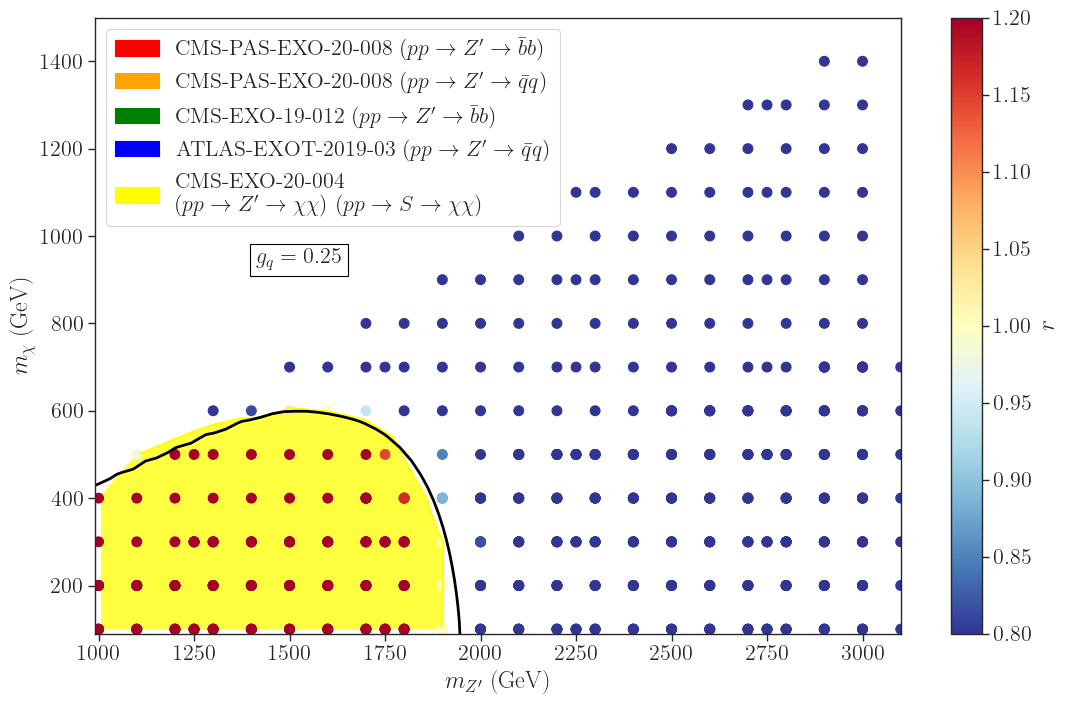

In [67]:
cm = plt.cm.get_cmap('RdYlBu_r')
plt.figure(figsize=(13,8))

contours, labels = [], []
gqv = 0.25
x = newDF_rescaled['mass.9900032'][newDF_rescaled['ExptRes.result.AnalysisID'] == 'CMS-EXO-20-004']
y = newDF_rescaled['mass.9000006'][newDF_rescaled['ExptRes.result.AnalysisID'] == 'CMS-EXO-20-004']
c = newDF_rescaled['ExptRes.result.r'][newDF_rescaled['ExptRes.result.AnalysisID'] == 'CMS-EXO-20-004']


for i, ana in enumerate(analysis):
    for txID in txnames:
        if ana == 'CMS-EXO-20-004' and txID != 'TRV1qq' and txID != 'TRV1bb':
            data = newDF_rescaled[(newDF_rescaled['ExptRes.result.AnalysisID']==ana)]
        else:  
#             data = newDF_rescaled[(newDF_rescaled['ExptRes.result.AnalysisID']==ana)]
#             data = data[data['ExptRes.result.TxNames'].isin([[txID]])]
            continue
        if len(data) == 0: continue
        rData = data['ExptRes.result.r'][data['ExptRes.result.AnalysisID'] == ana]
        pts = np.array([y for y in product(np.linspace(900.,4100.,300),np.linspace(0.,1800.,300))])
        rPts = griddata(list(zip(data['mass.9900032'],data['mass.9000006'])),rData,pts)
        pts = pts[~np.isnan(rPts)]
        rPts = rPts[~np.isnan(rPts)]
        
        cs = plt.tricontour(pts[:,0],pts[:,1],rPts,levels=[1.0],colors=colors[ana][txID])
        plt.tricontourf(pts[:,0],pts[:,1], rPts, levels=[1.0, max(rPts)], alpha=0.5,colors=colors[ana][txID])
        
            
l1 = mpatches.Patch(color='red', label=analysis[0]+' ('+convertLabel(txnames[0])+')')
l2 = mpatches.Patch(color='orange', label=analysis[0]+' ('+convertLabel(txnames[1])+')')
l3 = mpatches.Patch(color='green', label=analysis[2]+' ('+convertLabel(txnames[0])+')')
l4 = mpatches.Patch(color='blue', label=analysis[1]+' ('+convertLabel(txnames[1])+')')
l5 = mpatches.Patch(color='yellow', 
                    label=analysis[3]+'\n ('+convertLabel(txnames[-1])+') ('+convertLabel(txnames[-2])+')')
plt.legend(handles=[l1,l2,l3,l4,l5])
        

plt.scatter(x,y,c=c,s=50,cmap=cm, vmin=0.8,vmax=1.2)

plt.plot(cmsCurve['m_med_GeV'],cmsCurve['m_chi_GeV'],label='CMS-EXO-20-004 (axial)',linewidth=2,color='black')


# # plt.plot([x.min(),x.max()],[x.min(),x.max()],'--')
plt.colorbar(label=r'$r$')
plt.xlabel(r'$m_{Z^{\prime}}$ (GeV)')
plt.ylabel(r'$m_{\chi}$ (GeV)')
plt.text(0.2,0.6,r"$g_{q} = %1.2f$" %gqv,fontsize=16,bbox=dict(facecolor='white', edgecolor='black'),
         transform = plt.gca().transAxes)

plt.xlim(990.0, 3100.0)
plt.ylim(90.0,1500.0)

# plt.legend()
plt.show()